In [21]:
%pip install numpy matplotlib scipy librosa soundfile

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# FFT
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq

# Sunspots handling
from scipy.signal import find_peaks

# Audio handling
from IPython.display import Audio 
import soundfile as sf
import librosa
import librosa.display

# Image handling
import matplotlib.image as mpimg
from scipy.fft import fft2, ifft2

In [23]:
# Plot config
%matplotlib inline
plt.rcParams ['figure.figsize'] = [14, 5]
#%config InlineBackend.figure_format = 'retina'  # for better quality plots

# VTA MC2

### Aufgabe 1

### (a) - Fourier-Komponenten
> Implementieren Sie mit numpy eine Methode zur Berechnung der $k$-ten Fourier-Komponente einer Funktion, gegeben durch Arrays $x$ und $y$, mithilfe der Trapezregel (`np.trapz`).

$$
{\displaystyle c_{n}={\frac {1}{P}}\int _{-P/2}^{P/2}s(x)e^{-{\frac {2\pi inx}{P}}}\,dx\qquad {\text{for all integers}}~n}
$$


In [24]:
def fourier_component(x, y, k, P):
    """
    Calculate the k-th Fourier component of the function defined by arrays x and y.

    Parameters:
    x (numpy array): Array of x values.
    y (numpy array): Array of y values corresponding to s(x).
    k (int): The order of the Fourier component to calculate.
    P (float): The period of the function.

    Returns:
    complex: The k-th Fourier component.
    """
    # Calculate the integrand
    integrand = y * np.exp(-2j * np.pi * k * x / P)
    
    # Use the trapezoidal rule to approximate the integral
    integral = np.trapz(integrand, x)
    
    # Calculate the Fourier coefficient
    c_k = integral / P
    
    return c_k

### (b) - Fourier-Approximation
> Implementieren Sie mit numpy eine Methode zur Berechnung der Fourier-Approximation $f_{app}$ mit einer gegebenen Anzahl ($2m + 1$) von Fourier-Komponenten.

$$
{\displaystyle s(x)=\sum _{n=-\infty }^{\infty }c_{n}\cdot e^{\frac {2\pi inx}{P}}}
$$

In [25]:
def fourier_approximation(f, a, N, m):
    """
    Calculate the Fourier approximation of the function f over [-a, a] with (2m + 1) Fourier components.

    Parameters:
    f (function): The function to approximate.
    a (float): The interval length. The function will be approximated over [-a, a].
    N (int): The number of points to use in the approximation.
    m (int): The number of components on each side of zero to include.

    Returns:
    tuple: Arrays of x values, original y values, approximated y values, and Fourier coefficients.
    """
    # Define the x values
    x = np.linspace(-a, a, N)
    y = f(x)

    # Define the period
    P = 2 * a

    # Initialize the Fourier approximation array
    f_app = np.zeros_like(x, dtype=complex)
    f_coeff = []

    # Sum the Fourier series components
    for k in range(-m, m + 1):
        c_k = fourier_component(x, y, k, P)
        f_app += c_k * np.exp(2j * np.pi * k * x / P)
        f_coeff.append(c_k)
    
    return x, y, f_app.real, f_coeff

### (c) - Approximation einer Funktion
>Nähern Sie die Funktion $f_1(x) = \frac{1}{{e^x + e^{-x}}}$ auf dem Intervall $[-3, 3]$ (Auflösung: $N = 600$ Schritte) mit verschiedenen Anzahlen von Komponenten $2m + 1$. Plotten Sie den Vergleich zur Originalfunktion $f$.

$$
\mathrm{RE}=\frac{\left\|f(x)-\hat{f}(x)\right\|}{\|f(x)\|}
$$

wobei $f(x)$ die originale und $\hat{f}(x)$ die approximierte Funktion ist.

In [26]:
def rel_error(y, f_app):
    """
    Calculates the relative error between the actual values and the approximated values.

    Args:
        y (numpy.array): The actual y-values.
        f_app (numpy.array): The approximated y-values.
        
    Returns:
        float: The relative error between y and f_app.
    """
    return np.linalg.norm(y - f_app) / np.linalg.norm(y)

Die folgende Funktion vereinfacht die wiederholte Berechnungen und Darstellungen der Approximationen:

In [27]:
def plot_fourier_approx_and_err(f, a, N, m_values, calc_error=False, err_thresh=.001):
    """
    Plots the Fourier approximation of a given function and optionally calculates and plots the relative error.

    Args:
        f (function): The function to approximate.
        a (float): The interval length. The function will be approximated over [-a, a].
        N (int): The number of points to use in the approximation.
        m_values (list of int): List of the number of Fourier components to use in the approximations.
        calc_error (bool, optional): If true, calculate and plot the relative error. Defaults to False.
        err_thresh (float, optional): The error threshold. Used to draw a line on the error plot and print the minimum m. Defaults to .001.

    Returns:
        list of float: The relative errors for each approximation. Only returned if calc_error is True.
    """
    errors = []
    plt.figure(figsize=(14, 10))
    
    for i, m in enumerate(m_values):
        x, y, f_app, f_coeff = fourier_approximation(f=f, a=a, N=N, m=m)

        label_str = f"m = {m}"
        if calc_error:
            error = rel_error(y, f_app)
            errors.append(error)
            label_str += f", err = {error:.3f}"

        if i <= 3 or i == len(m_values) - 1:
            plt.plot(x, f_app, label=label_str)

    # Plot the original function
    plt.plot(x, y, label="Original Function", color='black')
    plt.title(f"Fourier Approximation (N={N}, a=[{-a},{a}])")
    plt.legend()
    plt.show()

    if calc_error:
        plt.figure()
        plt.plot(m_values, errors)
        plt.xlabel("Components (m)")
        plt.ylabel("Relative Error")
        plt.axhline(y=err_thresh, color="r", linestyle="--", label=f"{err_thresh*100}%")
        plt.title(f"Relative Error")
        plt.legend()
        plt.show()

        # Print the lowest number of components needed to be lower equal than the err_thresh
        try:
            indices = np.where(np.array(errors) <= err_thresh)[0]
            min_m_value = m_values[indices.min()]
            print(f"The lowest number of components needed to have an error lower or equal {err_thresh*100}% is: {min_m_value}")
        except ValueError:
            print(f"No components yield an error lower or equal to {err_thresh*100}%.")

    return errors if calc_error else None

In [28]:
def f1(x):
    """
    Compute the value of f1(x) = 1 / (exp(x) + exp(-x)).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return 1 / (np.exp(x) + np.exp(-x))

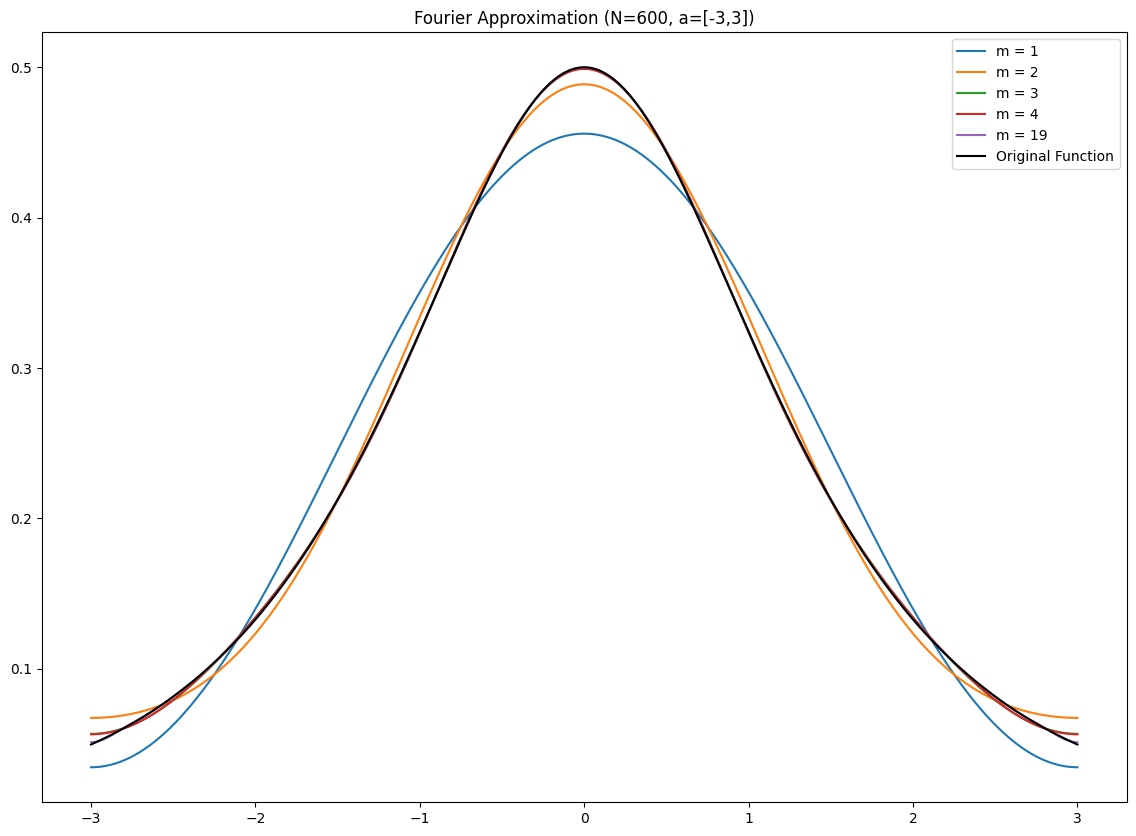

In [29]:
def f1(x):
    return 1 / (np.exp(x) + np.exp(-x))

plot_fourier_approx_and_err(f=f1, a=3, N=600, m_values=list(range(1, 20)))

### (d) - Fehlerberechnung
>Bestimmen Sie die Anzahl der Fourier-Komponenten, die benötigt werden, um eine Approximation mit höchstens $0,1$% relativen Fehler zu erhalten.

> **Note**: Um den relativen Fehler zu berechnen verwenden wir die bereits unter **(c)** notierte $RE$-Metrik.

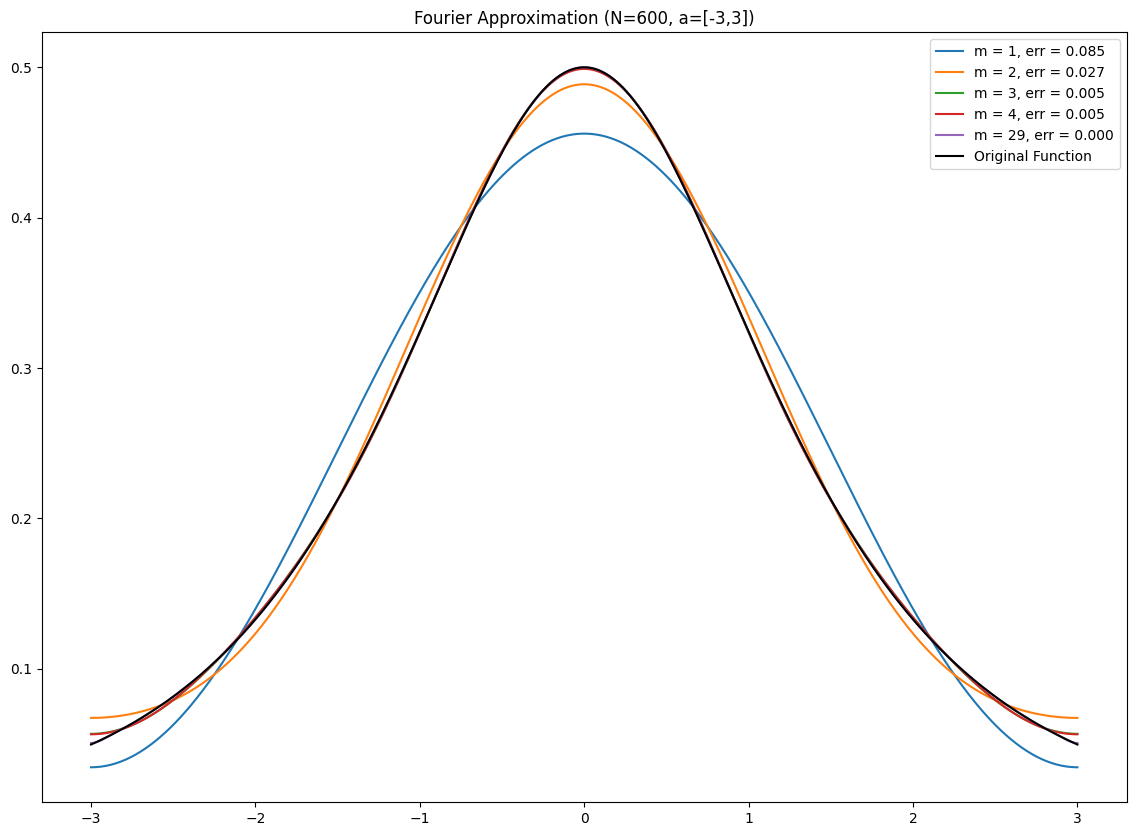

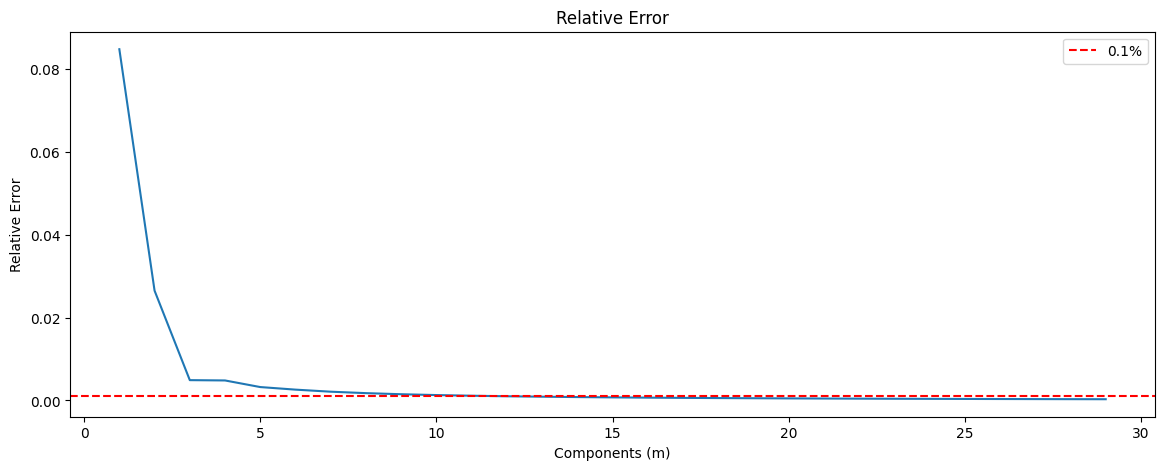

The lowest number of components needed to have an error lower or equal 0.1% is: 13


In [30]:
# Define the interval and number of steps
a = 3
N = 600

# Define the range of m_values to check (1 to 19)
m_values = list(range(1, 30))

# Plot the Fourier approximations and calculate relative errors
errors = plot_fourier_approx_and_err(f=f1, a=a, N=N, m_values=m_values, calc_error=True, err_thresh=0.001)

Für $f_1(x)$ gilt, dass der relative Fehler bei Komponente $13$ einen Wert unter $0.1\%$ annimmt.

Dies ist die hyperbolische Kosinusfunktion ($cosh(x)$), die eine gerade Funktion und symmetrisch zur $y$-Achse ist. Aus den Plots geht hervor, dass die Fourier-Reihe nur Kosinusterm beiträgt, da die Sinusterm aufgrund der Symmetrie verschwinden. Wie erwartet, ist die Konvergenz der Fourier-Reihe schnell und die Approximation sehr genau, was durch die hohe Übereinstimmung von Originalfunktion und Approximation in den Plots ersichtlich ist. Die Glätte der ursprünglichen Funktion fördert eine präzise Approximation.

### (e) - Approximation weiterer Funktionen
> Versuchen Sie die Funktionen $f_2(x) = e^x$ und $f_3(x) = e^{abs(x)}$ auf dem Intervall ($[-3, 3]$) (Auflösung: ($N = 600$ Schritte) mit einem $0,1$%igen Approximationsfehler anzunähern. Beschreiben und erklären Sie die Unterschiede.


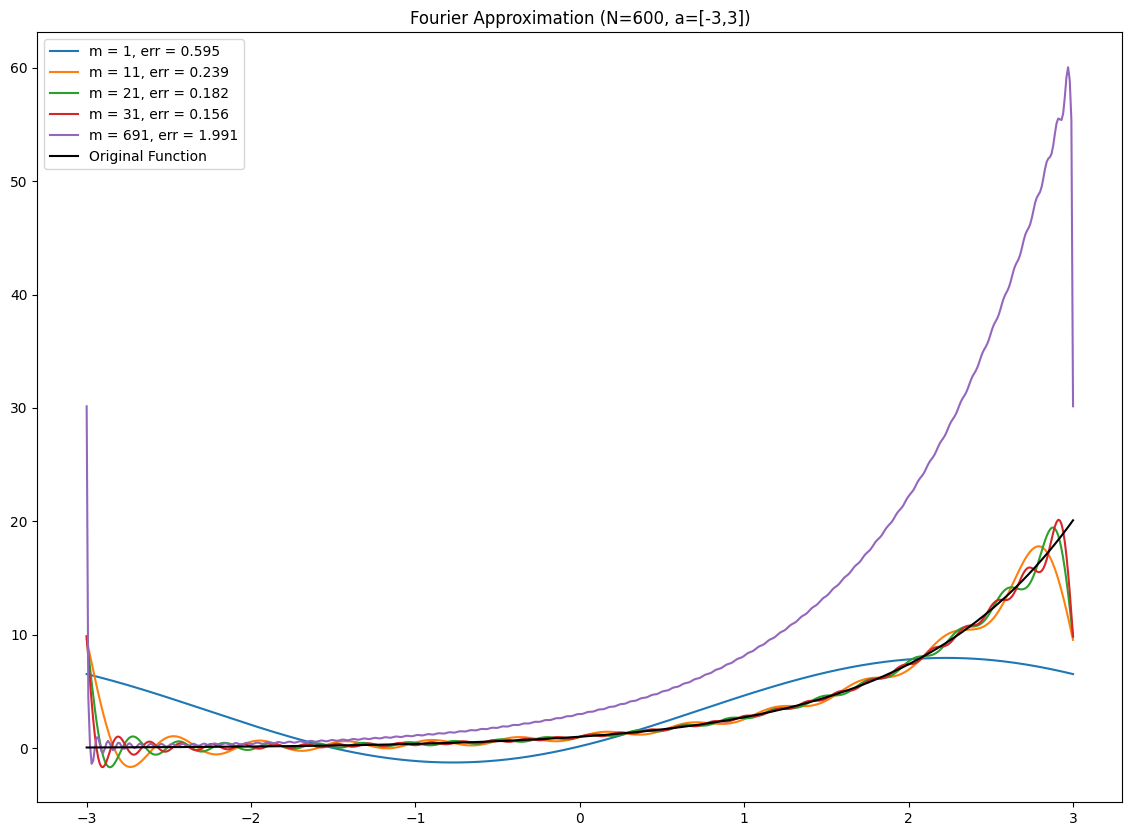

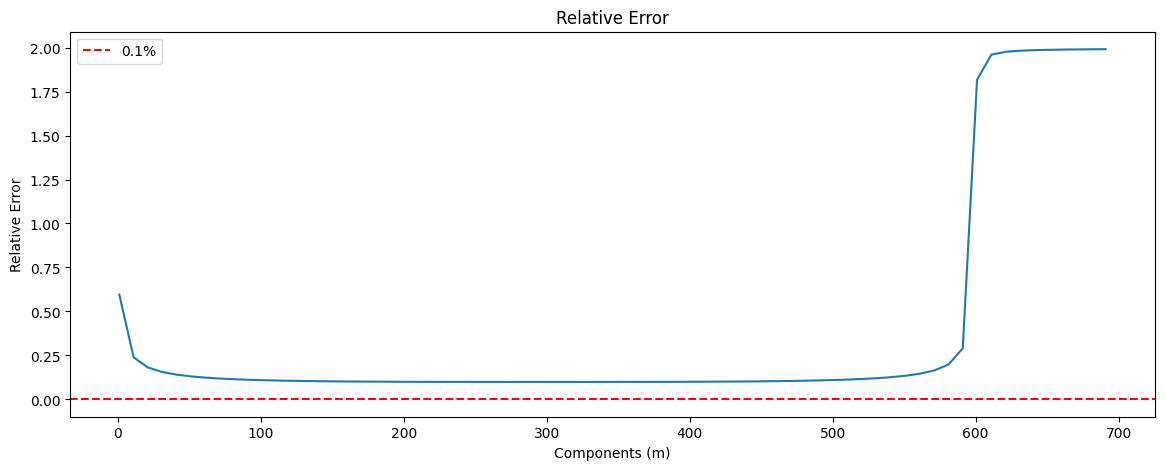

No components yield an error lower or equal to 0.1%.


In [31]:
def f2(x):
    """
    Compute the value of f2(x) = exp(x).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return np.exp(x)

# Define the interval and number of steps
a = 3
N = 600

# Define the range of m_values to check (1 to 19)
m_values = list(range(1, 700, 10))

# Plot the Fourier approximations and calculate relative errors
errors = plot_fourier_approx_and_err(f=f2, a=a, N=N, m_values=m_values, calc_error=True, err_thresh=0.001)

Der Fehler scheint bei $800$ Komponenten **nie** einen Fehler unter $0.1\%$ zu erreichen.

Diese Funktion ist weder gerade noch ungerade, und sie ist exponentiell wachsend. Da die Funktion auf dem Intervall $[-3,3]$ nicht periodisch ist, treten Randeffekte (`Gibbs-Phänomen`) auf, insbesondere an den Rändern des Intervalls, wo die Funktion ansteigt. Diese Funktion benötigt mehr Fourier-Terme benötigen, um innerhalb des gegebenen Fehlers zu bleiben, insbesondere aufgrund des exponentiellen Anstiegs.

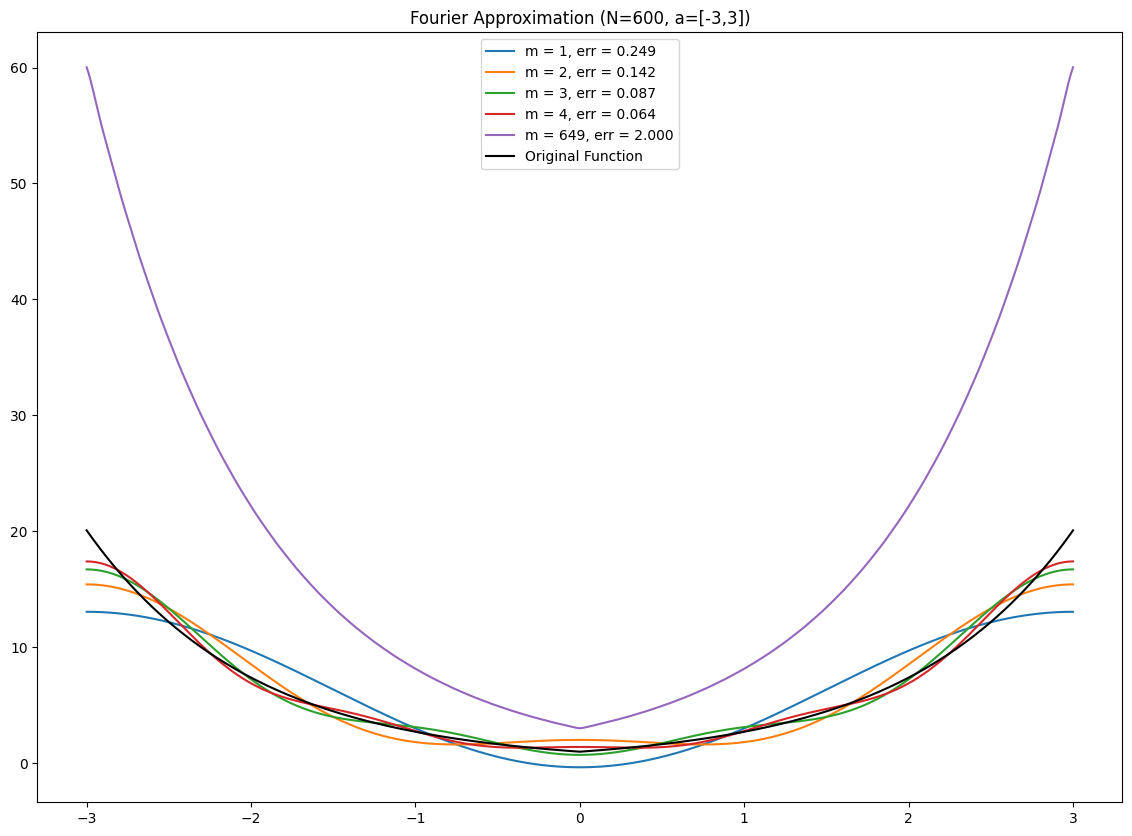

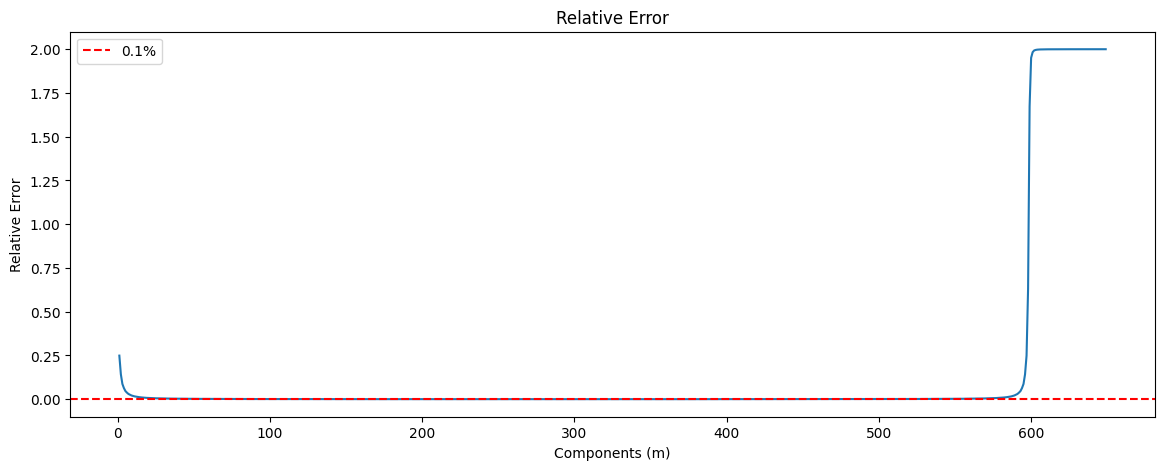

The lowest number of components needed to have an error lower or equal 0.1% is: 93


In [32]:
def f3(x):
    """
    Compute the value of f3(x) = exp(|x|).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return np.exp(np.abs(x))

# Define the interval and number of steps
a = 3
N = 600

# Define the range of m_values to check (1 to 799 in steps of 10)
m_values = list(range(1, 650))

# Plot the Fourier approximations and calculate relative errors
errors = plot_fourier_approx_and_err(f=f3, a=a, N=N, m_values=m_values, calc_error=True)

Wir können beobachten, dass der relative Fehler von $1$ bis $800$ Komponenten bei einer Auflösung von $N=600$ den tiefsten Fehler bei $93$ Komponenten annimmt. 

Ebenso wie $f2(x)$ ist diese Funktion nicht periodisch. Ein spezifisches Intervall wurde für die Fourier-Reihe ausgewählt. Es ist jedoch zu beachten, dass die Funktion $abs(x)$ eine Unstetigkeitsstelle bei $x=0$ erzeugt, was in den Plots durch die Diskontinuität bei $x=0$ offensichtlich wird. Dies führt dazu, dass die Konvergenz der Fourier-Reihe an dieser Stelle schwierig wird und das sogenannte `Gibbs-Phänomen` wieder auftritt. Dies ist in den Plots durch den plötzlichen Anstieg der Fourier-Approximation bei $x=0$ zu sehen.

#### Gibbs-Phänomen
Mit Hilfe von Fourier-Reihen lässt sich jede periodische Funktion als Summe von Sinus- und Kosinuswellen darstellen. Wenn wir jedoch versuchen, die Funktion mit einer endlichen Anzahl dieser Wellen zu approximieren, können wir in der Nähe von scharfen Kanten oder Ecken in der ursprünglichen Funktion einige zusätzliche Schwingungen sehen. Dies wird als Gibbs-Phänomen bezeichnet und kann zu Fehlern in unserer Näherung führen.

![](https://i.stack.imgur.com/oyNPh.png)

Referenz:
- [Gibbs phenomenon - Wikiwand](https://www.wikiwand.com/en/Gibbs_phenomenon)
- [Confusion regarding Gibbs phenomenon - stackexchange](https://math.stackexchange.com/questions/1780318/confusion-regarding-gibbs-phenomenon)
- [Fourier Series and Gibbs Phenomena [Matlab] - YouTube](https://youtu.be/98VixA3MjAc)

#### Overfitting

Ein Overfitting liegt vor, wenn ein Modell im Verhältnis zu der Menge und dem Rauschpegel der Daten, die es anzupassen versucht, übermässig komplex ist. Im Falle einer Fourier-Reihe kann jeder Term (Sinus- oder Kosinusfunktion) als ein Parameter oder Freiheitsgrad betrachtet werden, den das Modell zur Anpassung an die Daten verwenden kann. 

Wenn die Anzahl dieser Parameter (`m`) kleiner oder gleich der Anzahl der Datenpunkte (`N`) ist, kann jeder Parameter effektiv abgestimmt werden, um einen Aspekt der Daten zu erfassen. Wenn `m` jedoch `N` übersteigt, gibt es mehr Parameter als Datenpunkte. Das bedeutet, dass einige Parameter im Wesentlichen versuchen, auf dieselben Datenpunkte zu passen, was zu einem Overfitting führt.

Ein Overfit kann in diesem Zusammenhang zu starken Schwankungen zwischen den Datenpunkten führen, da die zusätzlichen Parameter es dem Modell ermöglichen, nicht nur die zugrunde liegende Funktion anzupassen, die die Daten erzeugt hat, sondern auch das zufällige Rauschen in den Daten. Mit anderen Worten, das Modell wird zu flexibel und fängt an, zufällige Variationen zu erfassen, die nicht Teil der wahren zugrunde liegenden Funktion sind. Aus diesem Grund steigt der relative Fehler sprunghaft an, wenn `m` grösser als `N` ist.

Im Wesentlichen versucht das Modell zu sehr, sich perfekt an die Daten anzupassen, und verliert dabei seine Fähigkeit, gut zu verallgemeinern, was sich in einem hohen Fehler beim Vergleich der Fourier-Näherung mit der tatsächlichen Funktion niederschlägt.

### Aufgabe 3

In dieser Aufgabe analysieren und bearbeiten Sie ein Musikstück (music.wav). Sie dürfen dafür
zB die fft routine von numpy oder scipy sowie das librosa und soundfile paket verwenden.

### (a) - Plot der Wellenform

Plotten Sie die Wellenform des Klangs (waveplot)- einmal vollständig und einmal für einen
kleinen Zeitberech, sodass die Wellenform deutlich wird- sowie das Amplitudenspektrum.
Wieso ist das Amplitudenspektrum symmetrisch bezüglich des Vorzeichens?

In [33]:
soundfile = sf.SoundFile('audio.wav')

LibsndfileError: Error opening 'audio.wav': System error.